# 1. Definition

In [20]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

class tuple_dict(dict):
    """
    Custom dict object accepting tuples as 'keys' and unpacking their elements
    to get dict items corresponding to keys contained within the tuple.
    """
    def __init__(self, *args):
        dict.__init__(self, args)

    def __getitem__(self, i):
        if type(i) == tuple:
            lst = []
            for n in i:
                lst.append(dict.__getitem__(self, n))
            return lst
        elif type(i) == str:
            return dict.__getitem__(self, i)


def get_outputs_at_each_layer(model, input_image, layer_type):
    """
    Returns outputs and gradients of the score function with respect to
    those layer-wise outputs. Restricts layer type for gradient calculation
    to optimize derivation with respect to feature maps of convolutional layers.
    This function works when eager mode in TensorFlow is enabled.
    :param model: tf.keras.models Model or Sequential object
    :param input_image: input image as a tf.Tensor
    :param layer_type: layer class e.g. tf.keras.layers.Conv2D
    :return: tuple of ouptuts of respective layers and gradients associated with them
    """
    with tf.GradientTape() as tape:
        outputs = tuple_dict()  # custom dict object
        outputs['input_image'] = input_image  # initialize first input
        # this is because the first layer doesn't take input from any other layer below
        restricted_outputs = []

        nodes_by_depth_keys = list(model._nodes_by_depth.keys())
        nodes_by_depth_keys.sort(reverse=True)  # this is the proper order of executing ops
        for k in nodes_by_depth_keys:
            nodes = model._nodes_by_depth[k]
            for n in nodes:
                config = n.get_config()  # returns a dict
                # inbound_node in config gets the input node
                # outbound_node in config points to the operation
                if type(config['outbound_layer']) == list:  # convert lists to tuples
                    obl = tuple(config['outbound_layer'])
                else:
                    obl = config['outbound_layer']
                if type(config['inbound_layers']) == list:
                    if len(config['inbound_layers']) == 0:
                        # we expect only the first layer inbound nodes to be non-existent
                        ibl = 'input_image'
                    else:
                        ibl = tuple(config['inbound_layers'])
                else:
                    ibl = config['inbound_layers']
                out = model.get_layer(obl)(outputs[ibl])  # magic happens here
                # we call each outbound node with its inbound nodes...
                outputs[obl] = out  # ...and we append it back to the dict containing outputs
                # keys in the dict are names of layers/nodes, which allows this loop
                # to get them anytime multiple inputs are needed
                if isinstance(model.get_layer(obl), layer_type):
                    # we return only those layers that we want to see (conv)
                    restricted_outputs.append(outputs[obl])
    gradients = tape.gradient(out, restricted_outputs)  # record 
    return restricted_outputs, gradients


def grad_cam(img, model, dim, return_switch=None, watch_layer_instances=tf.keras.layers.Conv2D):
    """
    Grad-CAM visualization function.
    :param image: path to image as a string
    :param model: tf.keras.models Model or Sequential object
    :param image_dims: tuple specifying size of the output photo
    :param return_switch: 'gradients', 'maps', 'both', 'upsampled' or 'summed'
                          switches output of the function to return gradients,
                          feature maps, both gradients and feature maps,
                          upsampled feature maps or summed feature maps respectively
    :param watch_layer_instances: single class or tuple of classes of layers to watch
                                  this is useful for tracking special offshoots of conv layers
    :return: values as specified by return_switch
    This function produces Grad-CAM plots as a side effect
    """
    print('input shape:',img.shape)
    image_dims = img.shape[:2]
    
    
    Image.fromarray(img.astype(np.uint8)).save("test.png")
    im_tf = Image.open('test.png')
    
    A_k, dy_dA_k = get_outputs_at_each_layer(model, tf.cast(np.expand_dims(img, axis=0), tf.float32), watch_layer_instances)
    L_c = [tf.keras.layers.ReLU()(tf.math.reduce_sum(tf.math.multiply(dy_dA_k[i], A_k[i]), axis=(3))) for i, _ in enumerate(dy_dA_k)]
    up_all = [np.array(Image.fromarray(i.numpy()[0, :, :]).resize(image_dims, resample=Image.BILINEAR)) for i in L_c]
    summed_maps = tf.keras.layers.ReLU()(np.sum(up_all, axis=0))
    
    if dim == 1: img = img.reshape(image_dims)
    
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(131)
    ax1.title.set_text('Gradient with 0.9 alpha')
    plt.axis('off')
    plt_im1 = plt.imshow(im_tf, interpolation='bilinear')
    plt_im2 = plt.imshow(summed_maps.numpy(), cmap='magma', alpha=.95, interpolation='nearest')

    ax2 = fig.add_subplot(132)
    ax2.title.set_text('Gradient with 0.6 alpha')
    plt.axis('off')
    plt_im1 = plt.imshow(im_tf, interpolation='bilinear')
    plt_im2 = plt.imshow(summed_maps.numpy(), cmap='magma', alpha=.6, interpolation='nearest')

    ax2 = fig.add_subplot(133)
    ax2.title.set_text('Original image')
    plt.axis('off')
    plt_im1 = plt.imshow(im_tf, interpolation='bilinear')
    plt.subplots_adjust(
        hspace = 4,
        wspace = 0.3,
        right = 0.8,
        left = - 0.8
    )
    plt.show()

    if isinstance(return_switch, str):
        if (return_switch == 'gradients'):
            return dy_dA_k
        elif (return_switch == 'both'):
            return A_k, dy_dA_k
        elif (return_switch == 'maps'):
            return A_k
        elif (return_switch == 'upsampled'):
            return up_all
        elif (return_switch == 'summed'):
            return summed_maps
        else:
            return None
    elif (return_switch is None):
        return None
    else:
        raise RuntimeError('Invalid return value switch!')
        
def show_cam_img(idx, x_test, y_test, y_pred):
    print('* real y : ', y_test[idx], '* predict y :' , y_pred[idx])
    grad_cam(x_test[idx], model, 3)

# 2. Dataset

In [16]:
data_path = '../6-CAM/result_2/'

In [19]:
x_test = np.load('%s/X_test.npy'%data_path)
y_test = np.load('%s/y_test.npy'%data_path)

x_test.shape, y_test.shape

((2776, 256, 256, 3), (2776, 5))

# 3. Build Model

### Base Model (EfficientNet b2) + Add layers

In [8]:
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.models import Model, load_model, Sequential

base_model = efn.EfficientNetB2(weights = 'imagenet', include_top = False, pooling = 'avg', input_shape = (256, 256, 3))
x = base_model.output
y = Dropout(0.5)(x)
y = Dense(1024, activation='relu')(y)
y = Dense(5, activation = 'sigmoid')(y)
model = Model(base_model.input, y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

 ### Load Weight

In [9]:
model.load_weights('./result_2/weight_Classification_200612_Adam_effb2.hdf5')

# 4. Plot CAM Image

In [11]:
y_pred = model.predict(x_test[:500])

* real y :  [0 1 0 0 0] * predict y : [0.00254342 0.97959435 0.00340408 0.1227783  0.3880284 ]
input shape: (256, 256, 3)


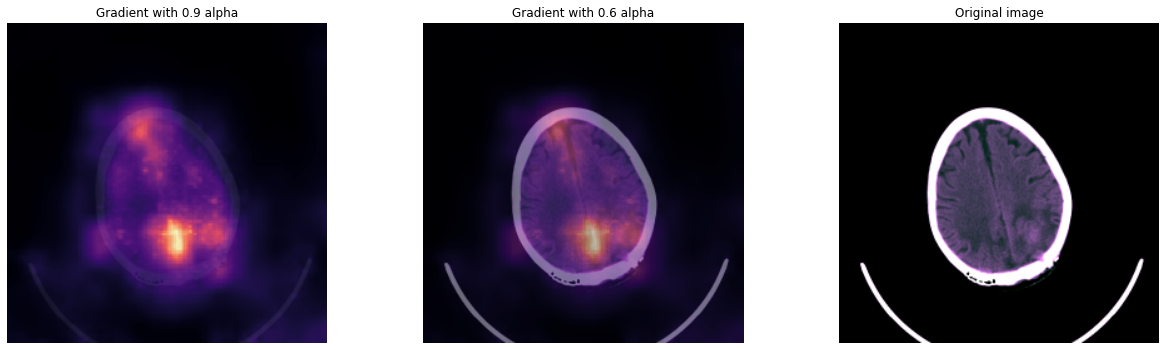

In [21]:
show_cam_img(1, x_test, y_test, y_pred)